In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

2025-12-06 11:35:51.300970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765020951.465080      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765020951.518703      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# ==============================================================================
# 1. KONFIGURASI
# ==============================================================================
FOLDER_DATA = "/kaggle/input/open-meteo-climate/open_meteo_climate/"
NAMA_FILE = "kebumen_75tahun_lengkap.csv"
PATH_FILE = os.path.join(FOLDER_DATA, NAMA_FILE)

# Label Kelas (Sesuai Request)
CLASSES = {
    0: "☀️ Berawan / Cerah (0 mm)",
    1: "☁️ Hujan Ringan (0.1 - 5 mm)",
    2: "🌧️ Hujan Sedang (5 - 10 mm)",
    3: "⛈️ Hujan Lebat (10 - 20 mm)"
}

In [15]:
# ==============================================================================
# 2. LOAD DATA & BERSIHKAN WAKTU
# ==============================================================================
def load_data(filepath):
    print(f"📂 Membaca file: {filepath}")
    if not os.path.exists(filepath):
        print("❌ File tidak ditemukan.")
        return None
    
    # Baca CSV
    df = pd.read_csv(filepath, index_col='date', parse_dates=True)
    
    # Perbaikan Zona Waktu (Agar tidak geser)
    # 1. Baca sebagai UTC
    df.index = pd.to_datetime(df.index, utc=True)
    # 2. Geser ke WIB
    df.index = df.index.tz_convert('Asia/Jakarta')
    # 3. Hapus label zona waktu (biar jadi jam dinding polos)
    df.index = df.index.tz_localize(None)
    
    df = df.sort_index()
    print(f"✅ Data Siap! Rentang: {df.index.min()} s.d {df.index.max()}")
    return df

df = load_data(PATH_FILE)

# Ambil data 10 tahun terakhir agar relevan dan training tidak terlalu lama
# (Silakan ubah tahunnya jika mau lebih banyak data)
df_ai = df.loc['1950':].copy()

📂 Membaca file: /kaggle/input/open-meteo-climate/open_meteo_climate/kebumen_75tahun_lengkap.csv
✅ Data Siap! Rentang: 1950-01-01 01:00:00 s.d 2025-12-05 23:00:00


In [20]:
df_ai.tail(10)

,temperature,humidity,dewpoint,rain_mm,wind_speed,wind_direction,pressure,weather_code,target_class,rain_lag_1,...,humidity_lag_6,humidity_lag_12,humidity_lag_24,pressure_lag_1,pressure_lag_2,pressure_lag_3,pressure_lag_4,pressure_lag_6,pressure_lag_12,pressure_lag_24
665534,28.638000,75.081850,23.788,0.1,10.261579,195.255170,1006.83260,51.0,1,1.7,...,83.653380,94.415130,93.373840,1007.73320,1008.62683,1009.42820,1009.92500,1010.41150,1008.99054,1008.20746
665535,27.388000,78.835020,23.388,0.7,7.729527,207.758450,1006.92350,53.0,1,0.1,...,78.674860,94.690470,88.193130,1006.83260,1007.73320,1008.62683,1009.42820,1010.41980,1008.88850,1007.90800
665536,26.138000,87.446830,23.888,0.8,3.396233,212.005340,1006.91440,53.0,1,0.7,...,76.424934,97.017850,94.746376,1006.92350,1006.83260,1007.73320,1008.62683,1009.92500,1009.18760,1007.80170
665537,25.588000,87.927580,23.438,1.1,2.340000,337.380100,1007.40910,55.0,1,0.8,...,75.331820,97.606190,92.766930,1006.91440,1006.92350,1006.83260,1007.73320,1009.42820,1009.18690,1008.59955
665538,24.737999,94.463745,23.788,1.6,2.526420,355.914460,1008.30096,61.0,1,1.1,...,77.101710,97.308525,97.326420,1007.40910,1006.91440,1006.92350,1006.83260,1008.62683,1009.78470,1009.39215
665539,24.138000,95.587100,23.388,2.4,2.930188,312.510400,1009.39410,61.0,1,1.6,...,73.795680,88.176530,98.213230,1008.30096,1007.40910,1006.91440,1006.92350,1007.73320,1010.20154,1010.49140
665540,23.888000,97.915070,23.538,2.3,5.762812,38.659830,1009.99090,61.0,1,2.4,...,75.081850,83.653380,97.915850,1009.39410,1008.30096,1007.40910,1006.91440,1006.83260,1010.41150,1010.49040
665541,23.938000,97.621240,23.538,0.9,3.438895,6.008918,1010.09125,53.0,1,2.3,...,78.835020,78.674860,96.162660,1009.99090,1009.39410,1008.30096,1007.40910,1006.92350,1010.41980,1010.59076
665542,23.788000,98.803024,23.588,0.2,4.327493,343.072400,1010.09010,51.0,1,0.9,...,87.446830,76.424934,95.583870,1010.09125,1009.99090,1009.39410,1008.30096,1006.91440,1009.92500,1010.49100
665543,23.788000,98.803024,23.588,0.8,2.346913,355.601380,1009.59110,53.0,1,0.2,...,87.927580,75.331820,95.585480,1010.09010,1010.09125,1009.99090,1009.39410,1007.40910,1009.42820,1009.99250


In [19]:
# ==============================================================================
# 3. FEATURE ENGINEERING (KELAS & MULTI-TIME LAG)
# ==============================================================================

# --- A. PEMBAGIAN KELAS (4 LEVEL) ---
def categorize_rain(mm):
    """Mengelompokkan curah hujan per jam menjadi 4 level."""
    if mm < 0.1:   return 0  # Tidak Hujan
    elif mm < 5.0: return 1  # Ringan
    elif mm < 10.0: return 2 # Sedang
    else:          return 3  # Lebat

# Terapkan kategori ke kolom target baru
df_ai['target_class'] = df_ai['rain_mm'].apply(categorize_rain)

# --- B. TIME LAG (FITUR MASA LALU UNTUK BANYAK KOLOM) ---
# 1. Tentukan kolom mana saja yang mau dibuatkan "memori"-nya
# Ganti nama kolom di bawah ini sesuai dengan nama kolom di data kamu!
fitur_untuk_lag = ['rain_mm', 'temperature', 'humidity', 'pressure'] 

# 2. Tentukan mau mundur berapa jam (misal: 1, 2, dan 3 jam lalu)
lags = [1, 2, 3, 4, 6, 12, 24] 

# 3. Loop otomatis untuk membuat kolom baru
for col in fitur_untuk_lag:
    # Cek dulu apakah kolomnya ada di data biar tidak error
    if col in df_ai.columns:
        for lag in lags:
            # Nama kolom baru: misal 'T2m_lag_1', 'RH_lag_2'
            col_name = f"{col}_lag_{lag}"
            df_ai[col_name] = df_ai[col].shift(lag)
    else:
        print(f"⚠️ Peringatan: Kolom '{col}' tidak ditemukan di data, dilewati.")

# --- C. PEMBERSIHAN (CLEANING) ---
# Hapus baris NaN akibat pergeseran data (shift)
df_ai = df_ai.dropna().reset_index(drop=True)

# --- CEK HASIL ---
print(f"\n✅ Total Data setelah lag & cleaning: {len(df_ai)} baris")
print(f"📊 Jumlah Fitur (Kolom) Sekarang: {len(df_ai.columns)}")

# Tampilkan contoh kolom T2m (Suhu) dan lag-nya
if 'T2m' in df_ai.columns:
    cols_show = ['T2m', 'T2m_lag_1', 'T2m_lag_2'] 
    print("\nContoh Lag pada Suhu (T2m):")
    print(df_ai[cols_show].head(5))


✅ Total Data setelah lag & cleaning: 665544 baris
📊 Jumlah Fitur (Kolom) Sekarang: 43


In [21]:
# ==============================================================================
# 4. PRE-PROCESSING (SCALING & WINDOWING)
# ==============================================================================
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- A. MENENTUKAN FITUR (X) & TARGET (y) ---

# 1. Fitur Utama (Sesuai request kamu)
fitur_utama = ['rain_mm', 'temperature', 'humidity', 'pressure']

# 2. Ambil otomatis semua kolom yang mengandung nama fitur utama + kolom lag-nya
# Ini trik biar kita tidak usah ngetik manual 'rain_lag_1', 'rain_lag_2', dst.
features = [col for col in df_ai.columns if any(x in col for x in fitur_utama)]

# 3. Target Output (Kita pakai target_class yang sudah dibuat di step 3)
target = 'target_class' 

print(f"✅ Jumlah Fitur Input (X): {len(features)} kolom")
print(f"   (Termasuk fitur asli dan semua lag yang telah dibuat)")
print(f"✅ Target Label (y): {target}")

# --- B. SCALING (MENYAMAKAN SKALA 0-1) ---
scaler = MinMaxScaler()
# Kita scale hanya kolom fitur (X), target (y) tidak perlu di-scale karena klasifikasi
X_scaled = scaler.fit_transform(df_ai[features])
y_raw = df_ai[target].values

# --- C. WINDOWING (MEMOTONG DATA BERDASARKAN WAKTU) ---
def create_windows(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# PENTING:
# Karena kita SUDAH punya fitur Lag (masa lalu) di kolom, 
# kita bisa set TIME_STEPS = 1 (atau angka kecil).
# Tapi jika kamu mau model melihat "urutan" data lag tersebut, kita bisa pakai angka lebih besar.
# Mari kita coba pakai 1 dulu karena kolomnya sudah mengandung informasi masa lalu (24 jam).
TIME_STEPS = 1 

print(f"\n✂️ Memotong data (Windowing) dengan Time Steps: {TIME_STEPS}...")
X_window, y_window = create_windows(X_scaled, y_raw, TIME_STEPS)

# --- D. SPLITTING DATA (LATIH & UJI) ---
# Split Training (80%) dan Testing (20%) - Tanpa mengacak urutan waktu
split_idx = int(len(X_window) * 0.80)

X_train, y_train = X_window[:split_idx], y_window[:split_idx]
X_test, y_test = X_window[split_idx:], y_window[split_idx:]

print(f"\n📊 Bentuk Data Siap Training:")
print(f"Data Latih (X_train): {X_train.shape}")
print(f"Label Latih (y_train): {y_train.shape}")
print(f"Data Uji  (X_test) : {X_test.shape}")

✅ Jumlah Fitur Input (X): 32 kolom
   (Termasuk fitur asli dan semua lag yang telah dibuat)
✅ Target Label (y): target_class

✂️ Memotong data (Windowing) dengan Time Steps: 1...

📊 Bentuk Data Siap Training:
Data Latih (X_train): (532434, 1, 32)
Label Latih (y_train): (532434,)
Data Uji  (X_test) : (133109, 1, 32)


In [22]:
# --- HITUNG CLASS WEIGHT (PENTING!) ---
# Agar AI tidak meremehkan hujan lebat yang jarang terjadi
weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = dict(enumerate(weights))
print("⚖️ Bobot Penyeimbang Kelas:", class_weights_dict)

⚖️ Bobot Penyeimbang Kelas: {0: 0.44066177809411883, 1: 0.5846733988395127, 2: 57.49827213822894, 3: 340.4309462915601}


In [31]:
# ==============================================================================
# 5. MEMBANGUN MODEL LSTM
# ==============================================================================
model = Sequential()

# --- LAYER 1: FEATURE EXTRACTION ---
# Unit diperbesar jadi 128 agar bisa menangkap pola cuaca yang rumit
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization()) # Menstabilkan aliran data biar belajar lebih cepat
model.add(Dropout(0.3))         # Mematikan 30% neuron secara acak biar gak manja (mencegah overfitting)

# --- LAYER 2: DEEP LEARNING ---
model.add(LSTM(64, return_sequences=True)) # Kita stack lagi LSTM-nya
model.add(BatchNormalization())
model.add(Dropout(0.3))

# --- LAYER 3: SUMMARY ---
model.add(LSTM(32, return_sequences=False)) # Layer LSTM terakhir tidak return sequence
model.add(BatchNormalization())
model.add(Dropout(0.3))

# --- LAYER 4: REASONING (DENSE LAYERS) ---
# Biarkan model "berpikir" dulu sebelum menebak kelas
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))

# --- OUTPUT LAYER ---
model.add(Dense(4, activation='softmax'))

# --- COMPILING DENGAN LEARNING RATE KHUSUS ---
# Kadang default learning rate terlalu cepat/lambat. Kita set manual.
opt = Adam(learning_rate=0.001) 

model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 128)         │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,476 (583.89 KB)

 Trainable params: 149,028 (582.14 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# ==============================================================================
# 6. TRAINING (MELATIH OTAK AI)
# ==============================================================================
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# B. Reduce LR: Kalau stuck, turunkan learning rate biar lebih teliti
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=1)

# C. Checkpoint: Simpan model terbaik selama proses
checkpoint = ModelCheckpoint('model_terbaik.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)
# Plot History Belajar
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Akurasi Latih')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Grafik Pembelajaran Model')
plt.legend()
plt.show()

Epoch 1/100
3743/3744 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4899 - loss: 1.0971
Epoch 1: val_accuracy improved from -inf to 0.57935, saving model to model_terbaik.keras
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 46s 11ms/step - accuracy: 0.4899 - loss: 1.0970 - val_accuracy: 0.5794 - val_loss: 0.8112 - learning_rate: 0.0010
Epoch 2/100
3741/3744 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5726 - loss: 0.8533
Epoch 2: val_accuracy improved from 0.57935 to 0.68845, saving model to model_terbaik.keras
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.5726 - loss: 0.8533 - val_accuracy: 0.6885 - val_loss: 0.6068 - learning_rate: 0.0010
Epoch 3/100
3742/3744 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6069 - loss: 0.8127
Epoch 3: val_accuracy did not improve from 0.68845
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.6069 - loss: 0.8127 - val_accuracy: 0.6882 - val_loss: 0.6442 - learning_rate: 0.0010
Epoch 4/100
3740/3744 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accur


📊 EVALUASI MODEL:
4160/4160 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
              precision    recall  f1-score   support

 Tidak Hujan       0.79      0.93      0.86     80145
      Ringan       0.84      0.51      0.63     52225
      Sedang       0.06      0.64      0.11       628
       Lebat       0.59      0.36      0.45       111

    accuracy                           0.76    133109
   macro avg       0.57      0.61      0.51    133109
weighted avg       0.80      0.76      0.76    133109

✅ Gambar berhasil disimpan sebagai 'confusion_matrix.png'


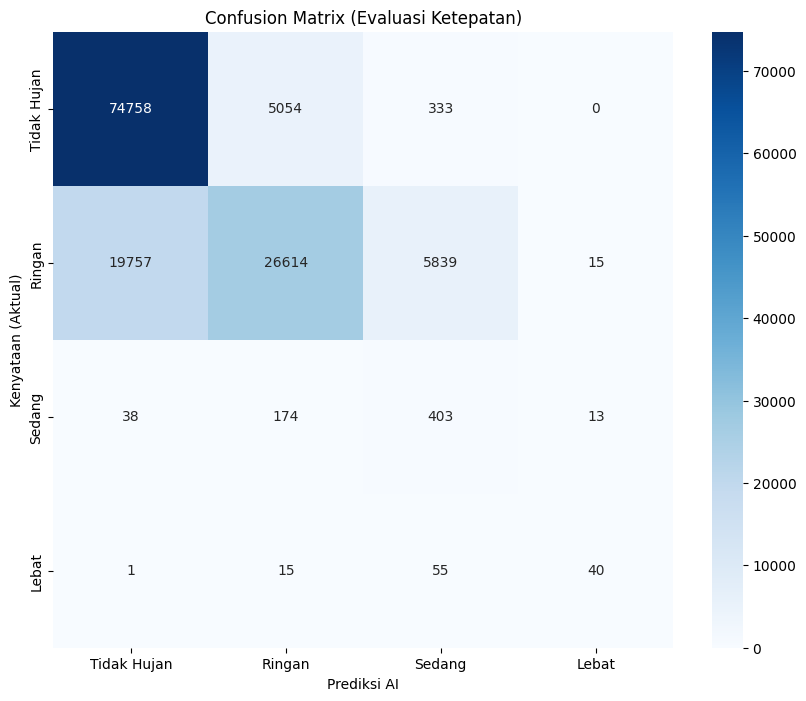

In [30]:
# ==============================================================================
# 7. EVALUASI HASIL (VERSI 4 KELAS)
# ==============================================================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n📊 EVALUASI MODEL:")

# 1. Prediksi Data Test
y_pred_prob = model.predict(X_test)
y_pred_class = np.argmax(y_pred_prob, axis=1)

# 2. Definisikan Nama Kelas (4 Level)
# Pastikan urutannya sesuai: 0, 1, 2, 3
CLASSES = {
    0: 'Tidak Hujan', 
    1: 'Ringan', 
    2: 'Sedang', 
    3: 'Lebat'
}
target_names = list(CLASSES.values()) # Mengambil daftar nama saja

# 3. Laporan Klasifikasi
# Kita pakai range(4) bukan range(5) karena kelasnya cuma ada 4
print(classification_report(y_test, y_pred_class, target_names=target_names))

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi AI')
plt.ylabel('Kenyataan (Aktual)')
plt.title('Confusion Matrix (Evaluasi Ketepatan)')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight') 
print("✅ Gambar berhasil disimpan sebagai 'confusion_matrix.png'")
plt.show()

In [26]:
# ==============================================================================
# 8. DEMO PREDIKSI (KARTU CUACA)
# ==============================================================================
def tampilkan_kartu_prediksi(input_24jam):
    """Menampilkan prediksi dengan gaya persentase."""
    input_reshaped = input_24jam.reshape(1, TIME_STEPS, len(features))
    probs = model.predict(input_reshaped, verbose=0)[0]
    
    pred_idx = np.argmax(probs)
    confidence = probs[pred_idx] * 100
    
    print("\n" + "="*50)
    print(f"🔮 PREDIKSI CUACA (1 Jam Kedepan)")
    print("="*50)
    
    print(f"Hasil Utama    : {CLASSES[pred_idx]}")
    print(f"Tingkat Yakin  : {confidence:.1f}%")
    print("-" * 50)
    
    print("Probabilitas:")
    for idx, label in CLASSES.items():
        score = probs[idx] * 100
        bar = "█" * int(score / 4)
        marker = "👈" if idx == pred_idx else ""
        print(f"{label:<30} : {score:>5.1f}% | {bar} {marker}")
    print("="*50)

# Coba cari data yang aslinya Hujan Lebat (Kelas 3 atau 4) untuk dites
print("\n🧪 DEMO HASIL PADA DATA BADAI:")
badai_indices = np.where(y_test >= 3)[0] # Cari kelas 3 atau 4

if len(badai_indices) > 0:
    # Ambil satu contoh
    sample_idx = badai_indices[0]
    tampilkan_kartu_prediksi(X_test[sample_idx])
else:
    print("Tidak ada data badai di set pengujian untuk didemokan.")


🧪 DEMO HASIL PADA DATA BADAI:

🔮 PREDIKSI CUACA (1 Jam Kedepan)
Hasil Utama    : 🌧️ Hujan Sedang (5 - 10 mm)
Tingkat Yakin  : 65.5%
--------------------------------------------------
Probabilitas:
☀️ Berawan / Cerah (0 mm)      :   0.1% |  
☁️ Hujan Ringan (0.1 - 5 mm)   :   5.8% | █ 
🌧️ Hujan Sedang (5 - 10 mm)    :  65.5% | ████████████████ 👈
⛈️ Hujan Lebat (10 - 20 mm)    :  28.5% | ███████ 


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=672c3bf7-b636-46e8-b7c0-4f6feec29313' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>